![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/extras/practica_tf_data.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica Extra No. 2**

## **Lectura de Archivos con TF Data, Generadores y Secuenciadores**

## **Objetivos**
- Aprender a usar las herramientas de Tensorflow Data y las herramientas de Keras para la lectura de archivos

In [1]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [68]:
import numpy as np
import pandas as pd

import os
from glob import glob
from scipy.io import loadmat

import random

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

from utils import general as gen

import cv2
from skimage import io

import re

from typing import Optional, Union, List, Tuple, ByteString

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
caltech_data = "1hbzc_P1FuxMkcabkgn9ZKinBwW683j45"

In [5]:
downloaded = drive.CreateFile({"id": caltech_data})
downloaded.GetContentFile("CUB_200_2011.tgz")

In [6]:
%%shell
tar -xzf CUB_200_2011.tgz
rm CUB_200_2011.tgz

## **Lectura y Preparación**
### **TF Dataset**
- Primero vamos a empezar con TF Data. Las funciones internas de TF son bastante rápidas, tanto en modo grafo como en modo eager. Por lo tanto, es la mejor opción que tenemos para hacer carga y lectura de datasets que no entran en memoria. Sin embargo, no es muy buena opción cuando se quiere hacer aumento de datos. Este tipo de datasets pueden usar tácticas de Boosting de manera muy sencilla, solo basta con leer la documentación disponible.

In [25]:
SIZE = (224, 224)
BATCH_SIZE = 64

In [45]:
classnames = None

with open("CUB_200_2011/classes.txt", "r") as f:
    classnames = f.readlines()

classnames = np.array(list(map(
    lambda x: x.replace("\n", "").split(" ")[1], 
    classnames
)))

In [47]:
image_ds = tf.data.Dataset.list_files("CUB_200_2011/*/*/*.jpg")

In [48]:
for f_ in image_ds.take(10):
    tf.print(f_)

CUB_200_2011/images/038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0036_29693.jpg
CUB_200_2011/images/007.Parakeet_Auklet/Parakeet_Auklet_0043_795948.jpg
CUB_200_2011/images/134.Cape_Glossy_Starling/Cape_Glossy_Starling_0070_129322.jpg
CUB_200_2011/images/198.Rock_Wren/Rock_Wren_0022_188958.jpg
CUB_200_2011/images/146.Forsters_Tern/Forsters_Tern_0049_151631.jpg
CUB_200_2011/images/025.Pelagic_Cormorant/Pelagic_Cormorant_0026_23792.jpg
CUB_200_2011/images/169.Magnolia_Warbler/Magnolia_Warbler_0020_166211.jpg
CUB_200_2011/images/076.Dark_eyed_Junco/Dark_Eyed_Junco_0063_67688.jpg
CUB_200_2011/images/054.Blue_Grosbeak/Blue_Grosbeak_0049_37180.jpg
CUB_200_2011/images/009.Brewer_Blackbird/Brewer_Blackbird_0109_2232.jpg


In [49]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == classnames
    return tf.argmax(one_hot)

@tf.function
def decode_image(file_path):
    label = get_label(file_path)

    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, SIZE)

    return image, label

@tf.function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, 0.2, 1.0)

    return image, label

In [50]:
image_ds = image_ds.map(decode_image, num_parallel_calls=16)
image_ds = image_ds.map(augment, num_parallel_calls=16)

In [51]:
imgs = []
labels = []

for img, label in image_ds.take(9):
    imgs.append(img.numpy())
    labels.append(label.numpy())

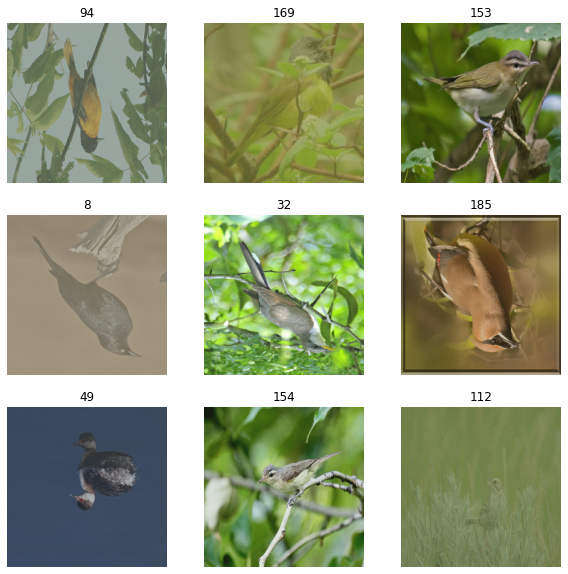

In [52]:
gen.visualize_subplot(
    imgs, labels, (3, 3), (10, 10)
)

### **Keras ImageDataGenerator**
- Esta es la forma de cargar datos favorita de todos. Se puede cargar datos desde carpetas o DataFrames de pandas, y hay una amplia gamma de funciones para aumentar datos. Sin embargo, si lo que se busca es desempeño, no es la mejor opción, puesto que su carga es lenta a comparación de TF Dataset. De igual forma, no permite tácticas de boosting como el prefetch o el uso de caches.

In [53]:
image_data_generator = ImageDataGenerator(
    horizontal_flip=True, vertical_flip=True, 
    zoom_range=0.5, rescale=1/255., 
    rotation_range=10, 
    fill_mode="constant",
)

image_generator = image_data_generator.flow_from_directory(
    "CUB_200_2011/images/", 
    target_size=SIZE, 
    batch_size=BATCH_SIZE,
    color_mode="rgb",
)

Found 11788 images belonging to 200 classes.


In [54]:
np.random.seed(1234)
random_batch = np.random.randint(0, len(image_generator))
X_batch, y_batch = image_generator[random_batch]

In [55]:
np.random.seed(1234)
random_sample = np.random.choice(len(X_batch), 9)

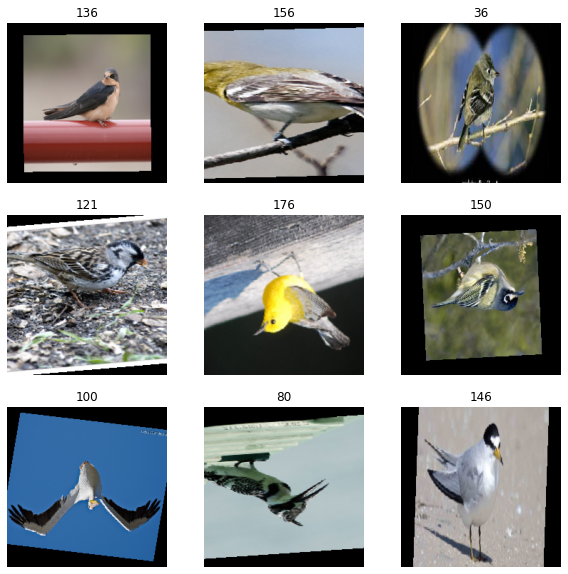

In [56]:
gen.visualize_subplot(
    X_batch[random_sample], y_batch[random_sample].argmax(axis=1),
    (3, 3), (10, 10),
)

### **Keras Sequence**
- Esta podría ser la forma menos convencional de cargar datos, puesto que no es muy conocida por los usuarios. Es una forma estándar de utilizar la carga y aplicar aumento de datos utilizando cualquier función de cualquier librería. En este caso, reducimos el tamaño de la imagen utilizando OpenCV. Aunque lento, es eficiente con respecto al uso de funciones que no son propias ni de TensorFlow ni de TF Dataset.

In [63]:
class ImageDataset(keras.utils.Sequence):
    def __init__(self, image_dirs):
        self.image_dirs = image_dirs

    def __len__(self):
        return len(self.image_dirs)

    def __getitem__(self, idx):
        file_path = self.image_dirs[idx]
        image = io.imread(file_path)
        image = cv2.resize(image, SIZE, cv2.INTER_LINEAR)
        # Do whatever you want
        label = file_path.split(os.path.sep)[-2]
        label = label == classnames
        return image, label.argmax()

In [69]:
image_dirs = glob("CUB_200_2011/*/*/*.jpg")
random.shuffle(image_dirs)

In [70]:
image_dataset = ImageDataset(image_dirs)

In [71]:
imgs = []
labels = []

for idx in range(9):
    img, label = image_dataset[idx]
    imgs.append(img)
    labels.append(label)

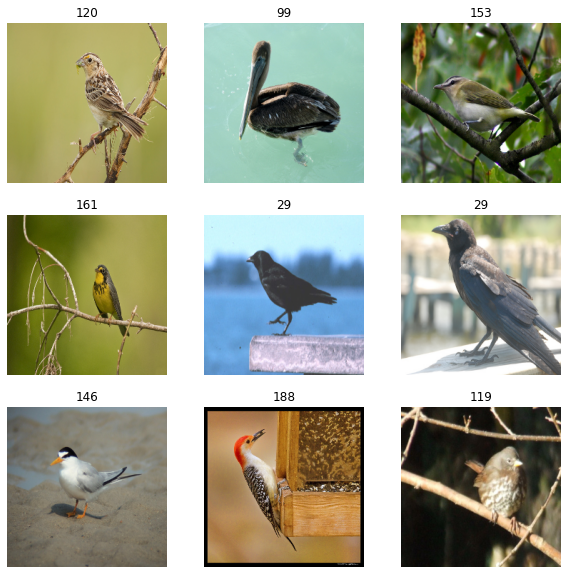

In [72]:
gen.visualize_subplot(
    imgs, labels, 
    (3, 3), (10, 10)
)